In [2]:
# # 최초 1회 실행
# !git clone -b main https://github.com/open-mmlab/mmsegmentation.git
# !pip install -U openmim
# !mim install mmengine
# !mim install 'mmcv >= 2.0.0rc1'

In [1]:
%cd mmsegmentation

/home/user/ai_test/mmsegmentation


In [2]:
import mmcv
import mmengine
import matplotlib.pyplot as plt
import os.path as osp
import numpy as np
from PIL import Image
import matplotlib.patches as mpatches

In [3]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset

In [4]:
# !mkdir checkpoints

In [5]:
# !wget https://download.openmmlab.com/mmsegmentation/v0.5/segformer/segformer_mit-b4_8x1_1024x1024_160k_cityscapes/segformer_mit-b4_8x1_1024x1024_160k_cityscapes_20211207_080709-07f6c333.pth \
#     -O checkpoints/segformer_mit-b4_8x1_1024x1024_160k_cityscapes_20211207_080709-07f6c333.pth

In [6]:
config_file = 'configs/segformer/segformer_mit-b4_8xb1-160k_cityscapes-1024x1024.py'
# checkpoint_file = 'checkpoints/segformer_mit-b4_8x1_1024x1024_160k_cityscapes_20211207_080709-07f6c333.pth'
checkpoint_file = 'work_dirs/segformer/iter_55000.pth'
save_pth_path = './work_dirs/tutorial'

In [7]:
import os.path as osp
import numpy as np
from PIL import Image
import cv2

# convert dataset annotation to semantic segmentation map

#수정 필요
data_root = '/home/user/ai_test/data'
img_dir = 'train_source_image2fish'
ann_dir = 'train_source_gt2fish'

# save pth 저장 경로
work_dir = './work_dirs/segformer1'

# define class and plaette for better visualization
classes = ('lens','Road', 'Sidewalk', 'Construction', 'Fence', 'Pole', 'Traffic Light',
           'Traffic Sign', 'Nature', 'Sky', 'Person', 'Rider', 'Car', 'Background')
palette = [
    [0, 0, 0],
    [255, 0, 0],
    [0, 255, 0],
    [0, 0, 255],
    [255, 255, 0],
    [0, 255, 255],
    [255, 0, 255],
    [0, 255, 255],
    [128, 0, 0],
    [0, 128, 0],
    [0, 0, 128],
    [128, 128, 0],
    [0, 128, 128],
    [255,255,255]
]


In [8]:
from mmseg.registry import DATASETS
from mmseg.datasets import BaseSegDataset
# from mmseg.datasets.builder import DATASETS
# from mmseg.datasets.custom import CustomDataset

# @DATASETS.register_module(force=True)
# class BuildingSemanticSegmentation(CustomDataset):
#     CLASSES = classes
#     PALETTE = palette
#     def __init__(self, split, **kwargs):
#         super().__init__(img_suffix='.png', seg_map_suffix='.png', split=split, **kwargs)
#         assert osp.exists(self.img_dir) and self.split is not None

@DATASETS.register_module()
class BuildingSemanticSegmentation(BaseSegDataset):
  METAINFO = dict(classes = classes, palette = palette)
  def __init__(self, **kwargs):
    super().__init__(img_suffix='.png', seg_map_suffix='.png', **kwargs)

In [9]:
from mmengine import Config
cfg = Config.fromfile(config_file)
# print(f'Config:\n{cfg.pretty_text}')

# train과 validation set 합친 다음에 나눠야함. 일단 구현 x

In [10]:
# import os.path as osp
# import numpy as np
# from PIL import Image

# # convert dataset annotation to semantic segmentation map
# for file in mmengine.scandir(osp.join(data_root, ann_dir), suffix='.regions.txt'):
#   seg_map = np.loadtxt(osp.join(data_root, ann_dir, file)).astype(np.uint8)
#   seg_img = Image.fromarray(seg_map).convert('P')
#   seg_img.putpalette(np.array(palette, dtype=np.uint8))
#   seg_img.save(osp.join(data_root, ann_dir, file.replace('.regions.txt',
#                                                          '.png')))

In [11]:
# #수정 필요
# split_dir = data_root + '/splits'
# mmengine.mkdir_or_exist(osp.join(data_root, split_dir))
# filename_list = [osp.splitext(filename)[0] for filename in mmengine.scandir(
#     osp.join(data_root, ann_dir), suffix='.png')]
# with open(osp.join(data_root, split_dir, 'train.txt'), 'w') as f:
#   # select first 4/5 as train set
#   train_length = int(len(filename_list)*9/10)
#   f.writelines(line + '\n' for line in filename_list[:train_length])
# with open(osp.join(data_root, split_dir, 'val.txt'), 'w') as f:
#   # select last 1/5 as train set
#   f.writelines(line + '\n' for line in filename_list[train_length:])

In [12]:

# Since we use only one GPU, BN is used instead of SyncBN
# cfg.norm_cfg = dict(type='SyncBN', requires_grad=True)
cfg.crop_size = (1024,512)
cfg.model.data_preprocessor.size = cfg.crop_size
#cfg.model.backbone.norm_cfg = cfg.norm_cfg
# cfg.model.backbone.norm_cfg = dict(type='BN', requires_grad=True)#cfg.norm_cfg
# cfg.model.decode_head.norm_cfg = cfg.norm_cfg
#cfg.model.auxiliary_head.norm_cfg = cfg.norm_cfg
# modify num classes of the model in decode/auxiliary head
cfg.model.decode_head.num_classes = 13
#cfg.model.auxiliary_head.num_classes = 2

# Modify dataset type and path
cfg.dataset_type = 'BuildingSemanticSegmentation'
cfg.data_root = data_root

cfg.train_dataloader.batch_size = 2
#cfg.test_dataloader.batch_size = 16

cfg.model.decode_head.loss_decode = [dict(type='FocalLoss')]

                                    #  [
                                    #  dict(type='CrossEntropyLoss', use_sigmoid=True, loss_weight = 1.0),
                                    #  dict(type='LovaszLoss', loss_weight = 10.0, reduction='none')]

albu_train_transforms = [
    #dict(type='RandomRotate90', p=0.5),
    dict(type='RandomBrightnessContrast',brightness_limit=0.1, contrast_limit=0.15, p=0.5),
    dict(type='CLAHE', clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5),
    dict(type='HueSaturationValue', hue_shift_limit=15, sat_shift_limit=25, val_shift_limit=10, p=0.5),
    dict(type='MotionBlur', blur_limit=25, allow_shifted=True, always_apply=False, p=0.3),
    dict(type='ZoomBlur', max_factor=1.31, step_factor=(0.01, 0.03), always_apply=False, p=0.3),
]

cfg.train_pipeline = [
    dict(type='LoadImageFromFile'),
    dict(type='LoadAnnotations'),
    dict(
        type='Albu',
        transforms=albu_train_transforms,
        keymap=dict(img='image', gt_semantic_seg='mask'),
        update_pad_shape=True,
        ),
    dict(type='RandomFlip', prob=0.5),
    #dict(type='RandomRotate',degree=90, prob=0.5),
    dict(type='PhotoMetricDistortion'),
    # RandomMosaic
    dict(type='RandomCrop', crop_size=cfg.crop_size, cat_max_ratio=1),
    #dict(type='Resize', scale=(1024, 512), keep_ratio=True),
    dict(type='PackSegInputs')
]



cfg.test_pipeline = [
    dict(type='LoadImageFromFile'),
    # dict(type='Resize', scale=(224, 224), keep_ratio=True),
    # add loading annotation after ``Resize`` because ground truth
    # does not need to do resize data transform
    dict(type='LoadAnnotations'),
    dict(type='PackSegInputs')
]


cfg.train_dataloader.dataset.type = cfg.dataset_type
cfg.train_dataloader.dataset.data_root = cfg.data_root
cfg.train_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.train_dataloader.dataset.pipeline = cfg.train_pipeline
cfg.train_dataloader.dataset.ann_file = data_root + '/splits/train.txt'

cfg.val_dataloader.dataset.type = cfg.dataset_type
cfg.val_dataloader.dataset.data_root = cfg.data_root
cfg.val_dataloader.dataset.data_prefix = dict(img_path=img_dir, seg_map_path=ann_dir)
cfg.val_dataloader.dataset.pipeline = cfg.test_pipeline
cfg.val_dataloader.dataset.ann_file = data_root + '/splits/val.txt'

cfg.test_dataloader = cfg.val_dataloader


# Load the pretrained weights
cfg.load_from = checkpoint_file

# Set up working dir to save files and logs.
cfg.work_dir = work_dir


#수정 필요 (실행 확인을 위해 작은 숫자로 테스트해보고 되면 주석처리 된 숫자로 하시면 됩니다.)
cfg.train_cfg.max_iters = 100000#100000
cfg.train_cfg.val_interval = 5000#5000
#cfg.train_cfg.val_evaluator = dict(type='IoUMetric', iou_metrics=['mDice'])
cfg.default_hooks.logger.interval = 1000#1000
cfg.default_hooks.checkpoint.save_best = "mIoU"
cfg.val_evaluator = dict(type='IoUMetric', iou_metrics=['mIoU'])

#cfg.train_cfg.val_evaluator = dict(interval=200, metric='mDice', pre_eval=True)
#cfg.val_evaluator = dict(interval=4000, metric='mDice', pre_eval=True)
#evaluation = dict(interval=4000, metric='mDice', pre_eval=True)


cfg.default_hooks.checkpoint.interval = 5000#5000

cfg.device = 'cuda'
cfg.gpu_ids = 0

# Set seed to facilitate reproducing the result
cfg['randomness'] = dict(seed=0)

# Let's have a look at the final config used for training
#print(f'Config:\n{cfg.pretty_text}')

In [13]:
from mmengine.runner import Runner

runner = Runner.from_cfg(cfg)

09/04 07:45:59 - mmengine - INFO - 
------------------------------------------------------------
System environment:
    sys.platform: linux
    Python: 3.9.0 (default, Nov 15 2020, 14:28:56) [GCC 7.3.0]
    CUDA available: True
    numpy_random_seed: 0
    GPU 0: NVIDIA GeForce RTX 3080
    CUDA_HOME: /usr/local/cuda-11.8
    NVCC: Cuda compilation tools, release 11.8, V11.8.89
    GCC: gcc (Ubuntu 11.4.0-1ubuntu1~22.04) 11.4.0
    PyTorch: 2.0.1+cu117
    PyTorch compiling details: PyTorch built with:
  - GCC 9.3
  - C++ Version: 201703
  - Intel(R) oneAPI Math Kernel Library Version 2022.2-Product Build 20220804 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v2.7.3 (Git Hash 6dbeffbae1f23cbbeae17adb7b5b13f1f37c080e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - LAPACK is enabled (usually provided by MKL)
  - NNPACK is enabled
  - CPU capability usage: AVX2
  - CUDA Runtime 11.7
  - NVCC architecture flags: -gencode;arch=compute_37,code=sm_37;-gencode;arch=compute_50,code

/home/user/ai_test/mmsegmentation/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '


09/04 07:46:00 - mmengine - INFO - Distributed training is not used, all SyncBatchNorm (SyncBN) layers in the model will be automatically reverted to BatchNormXd layers if they are used.
09/04 07:46:00 - mmengine - INFO - Hooks will be executed in the following order:
before_run:
(VERY_HIGH   ) RuntimeInfoHook                    
(BELOW_NORMAL) LoggerHook                         
 -------------------- 
before_train:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(VERY_LOW    ) CheckpointHook                     
 -------------------- 
before_train_epoch:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
(NORMAL      ) DistSamplerSeedHook                
 -------------------- 
before_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                    
(NORMAL      ) IterTimerHook                      
 -------------------- 
after_train_iter:
(VERY_HIGH   ) RuntimeInfoHook                

/home/user/ai_test/mmsegmentation/mmseg/engine/hooks/visualization_hook.py:61: UserWarning: The draw is False, it means that the hook for visualization will not take effect. The results will NOT be visualized or stored.
  warnings.warn('The draw is False, it means that the '


In [14]:
# start training
runner.train()

09/04 07:46:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:lr=6e-05
09/04 07:46:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:weight_decay=0.0
09/04 07:46:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.weight:decay_mult=0.0
09/04 07:46:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:lr=6e-05
09/04 07:46:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:weight_decay=0.0
09/04 07:46:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.0.norm.bias:decay_mult=0.0
09/04 07:46:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:lr=6e-05
09/04 07:46:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:weight_decay=0.0
09/04 07:46:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm1.weight:decay_mult=0.0
09/04 07:46:01 - mmengine - INFO - paramwise_options -- backbone.layers.0.1.0.norm

KeyboardInterrupt: 

Loads checkpoint by local backend from path: ./work_dirs/hrnet/best_mIoU_iter_20000.pth


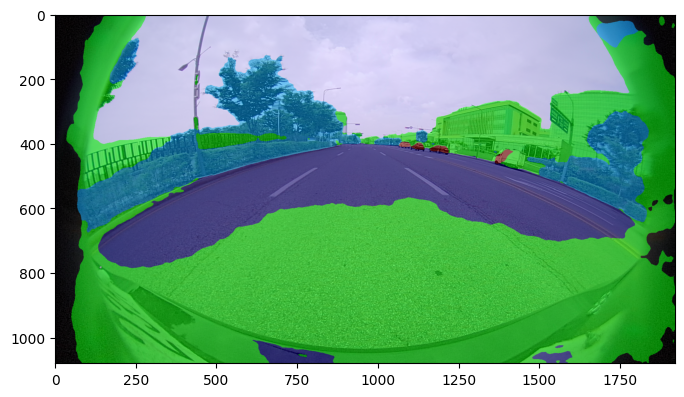

In [35]:
from mmseg.apis import init_model, inference_model, show_result_pyplot

# Init the model from the config and the checkpoint
checkpoint_path = './work_dirs/hrnet/best_mIoU_iter_20000.pth'
# checkpoint_path = checkpoint_file
model = init_model(cfg, checkpoint_path, 'cuda:0')

img = mmcv.imread(data_root + '/test_image/TEST_0005.png')
pred = inference_model(model, img)
plt.figure(figsize=(8, 6))
vis_result = show_result_pyplot(model, img, pred)
plt.imshow(mmcv.bgr2rgb(vis_result))

In [36]:
outputs = pred.pred_sem_seg.data
outputs = outputs.cpu().numpy()
np.unique(outputs)

array([ 0,  1,  3,  8,  9, 12, 13])

: 

In [ ]:
def rle_encode(mask):
    pixels = mask.flatten()
    pixels = np.concatenate([[0], pixels, [0]])
    runs = np.where(pixels[1:] != pixels[:-1])[0] + 1
    runs[1::2] -= runs[::2]
    return ' '.join(str(x) for x in runs)

In [ ]:
from glob import glob

test_image_path = sorted(glob("/content/drive/MyDrive/Colab Notebooks/data/test_image/*"))
for path in test_image_path:
  print(path)

In [ ]:
from tqdm.auto import tqdm

answer = []
for path in tqdm(test_image_path):
  img = mmcv.imread(path)
  model_pred = inference_model(model, img)
  outputs = model_pred.pred_sem_seg.data
  outputs = outputs.squeeze()
  outputs = outputs.cpu().numpy()

  pred = outputs.astype(np.uint8)
  pred = Image.fromarray(pred) # 이미지로 변환
  pred = pred.resize((960, 540), Image.NEAREST) # 960 x 540 사이즈로 변환
  pred = np.array(pred) # 다시 수치로 변환
  # class 0 ~ 11에 해당하는 경우에 마스크 형성 / 12(배경)는 제외하고 진행
  for class_id in range(12):
      class_mask = (pred == class_id).astype(np.uint8)
      if np.sum(class_mask) > 0: # 마스크가 존재하는 경우 encode
          mask_rle = rle_encode(class_mask)
          answer.append(mask_rle)
      else: # 마스크가 존재하지 않는 경우 -1
          answer.append(-1)


In [ ]:
import pandas as pd
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/sample_submission.csv')
submit['mask_rle'] = answer
submit
submit.to_csv('./baseline_submit.csv', index=False)